# Overfitting: toy example with two nearby lines
The data set consits of two data subsets:  
- data set 1: $n_1$ samples from the graph $y=b_1+w_1x$;  
- data set 2: $n_2$ samples from the graph $y=b_2+w_2x$.  

We train a linear regressor in the different scenarios.
1.  **Standard**.  The training set is taken to be data set 1 while the validation set is taken to be data set2.  The parameters are chosen in such a way that, in an initial phase, the validation loss is less than the training loss, but then the validation loss increases and converges while the training loss continius to decrease and converges to a lower value.  
2. **Aternating**.  The training and validation sets alternate with a fixed period, between data sets 1 and data sets 2.  The training loss displays a sawtooth pattern, with an upward discontinuous jump when the training and validation sets are switched.  
3.  **Reshuffled**.  The training and validation sets are reshuffled, from the whole data set, with a fixed period.

---
tags: pytorch, exploration, overfitting, underfitting, hyper-parameter tuning

In [1]:
from tqdm import tqdm

import numpy as np
import torch
from torch.nn import Linear, MSELoss
from torch.optim import SGD

import matplotlib.pyplot as plt
%matplotlib inline

# Standard scheme
The training and validation sets are taken to be data set 1 and 2 respectively.

In [2]:
def scheme_standard(c0, c1, c2, n_epochs, lr, n_interm):
    b0, w0 = c0
    n1, b1, w1 = c1
    n2, b2, w2 = c2

    x1 = -1. + 2.*torch.rand(n1, 1)
    y1 = b1 + w1*x1

    x2 = -1. + 2.*torch.rand(n2, 1)
    y2 = b2 + w2*x2
 
    h = n_epochs//n_interm # step when slicing to plot intermediate regressors

    # Setup
    model = Linear(1, 1)
    model.weight.data = torch.tensor(w0).view(*model.weight.data.shape)
    model.bias.data = torch.tensor(b0).view(*model.bias.data.shape)


    criterion = MSELoss()
    optimizer = SGD(model.parameters(), lr=lr)

    losses = {}
    losses['training'] = []
    losses['validation'] = []
    weights = []
    biases = []

    # Training
    for _ in tqdm(range(n_epochs)):
        weights.append(model.weight.data.item())
        biases.append(model.bias.data.item())
        with torch.no_grad():
            preds_v = model(x2)
            loss_v = criterion(preds_v, y2)
        losses['validation'].append(loss_v.data.item())
        optimizer.zero_grad()
        preds = model(x1)
        loss = criterion(preds, y1)    
        losses['training'].append(loss.data.item())
        loss.backward()

        optimizer.step()

    weights = torch.tensor(weights).view(1, n_epochs)
    biases = torch.tensor(biases).view(1, n_epochs)

    # Intermediate regressors
    x = torch.linspace(-1., 1., 2).view(-1, 1)
    inputs = torch.ones_like(weights)*x
    outputs = weights*x + biases

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    ax = axs[0]
    ax.plot(x1, y1, '.', label='data set 1')
    ax.plot(x2, y2, '.', label='data set 2');
    ax.plot(inputs[:,::h], outputs[:,::h], ":k", alpha=.6);
    ax.plot(inputs[:,-1], outputs[:,-1], 'k', label='predictions')
    ax.set_xlabel("x", fontsize=14)
    ax.set_ylabel("y", fontsize=14)    
    ax.set_title("Intermediate regressors", fontsize=22)
    ax.legend();
    ax.grid();

    ax = axs[1]
    ax.plot(losses['training'], label='training')
    ax.plot(losses['validation'], label='validation')
    ax.set_xlabel("iteration", fontsize=14)
    ax.set_ylabel("MSE", fontsize=14)
    ax.set_title("Losses along training", fontsize=22)
    ax.legend()
    ax.grid()
    ax.set_yscale('log');
    
    fig.suptitle("Training on data set 1", fontsize=22, y=1.03);

100%|██████████| 40/40 [00:00<00:00, 3980.83it/s]


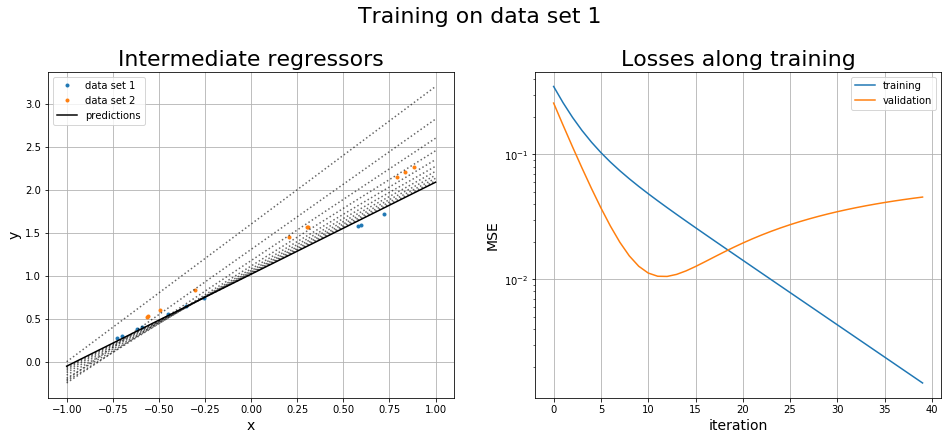

In [3]:
n1, b1, w1 = 10, 1., 1.
c1 = [n1, b1, w1]

n2, b2, w2 = 10, b1 + .2, w1 + .2
c2 = [n2, b2, w2]

b0, w0 = b2 + .4, w2 + .4
c0 = [b0, w0]

lr = .1
n_epochs = 40
n_interm = 10 # approximate number of intermediate regressors to plot

scheme_standard(c0, c1, c2, n_epochs, lr, n_interm)

# Aternating scheme
The training and validation sets alternate with a fixed period, between data sets 1 and data sets 2. 

In [4]:
def scheme_alternate(c0, c1, c2, n_epochs, lr, n_interm, period):
    r"""Training alternates data sets 1 and 2 as training and validation sets, with a period `period`.
    """
    b0, w0 = c0
    n1, b1, w1 = c1
    n2, b2, w2 = c2

    x1 = -1. + 2.*torch.rand(n1, 1)
    y1 = b1 + w1*x1

    x2 = -1. + 2.*torch.rand(n2, 1)
    y2 = b2 + w2*x2
 
    h = n_epochs//n_interm # step when slicing to plot intermediate regressors

    # Setup
    model = Linear(1, 1)
    model.weight.data = torch.tensor(w0).view(*model.weight.data.shape)
    model.bias.data = torch.tensor(b0).view(*model.bias.data.shape)


    criterion = MSELoss()
    optimizer = SGD(model.parameters(), lr=lr)

    losses = {}
    losses['training'] = []
    losses['validation'] = []
    weights = []
    biases = []

    # Training
    for i in tqdm(range(n_epochs)):
        if i % period:
            xt, xv = x1, x2
            yt, yv = y1, y2
        else:
            xt, xv = x1, x2
            yt, yv = y2, y1
        weights.append(model.weight.data.item())
        biases.append(model.bias.data.item())
        with torch.no_grad():
            preds_v = model(xt)
            loss_v = criterion(preds_v, yv)
        losses['validation'].append(loss_v.data.item())
        optimizer.zero_grad()
        preds_t = model(xt)
        loss_t = criterion(preds_t, yt)    
        losses['training'].append(loss_t.data.item())
        loss_t.backward()

        optimizer.step()

    weights = torch.tensor(weights).view(1, n_epochs)
    biases = torch.tensor(biases).view(1, n_epochs)

    # Intermediate regressors
    x = torch.linspace(-1., 1., 2).view(-1, 1)
    inputs = torch.ones_like(weights)*x
    outputs = weights*x + biases

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    ax = axs[0]
    ax.plot(x1, y1, '.', label='data set 1')
    ax.plot(x2, y2, '.', label='data set 2');
    ax.plot(inputs[:,::h], outputs[:,::h], ":k", alpha=.6);
    ax.plot(inputs[:,-1], outputs[:,-1], 'k', label='predictions')
    ax.set_xlabel("x", fontsize=14)
    ax.set_ylabel("y", fontsize=14)    
    ax.set_title("Intermediate regressors", fontsize=22)
    ax.legend();
    ax.grid();

    ax = axs[1]
    ax.plot(losses['training'], label='training')
    ax.plot(losses['validation'], label='validation')
    ax.set_xlabel("iteration", fontsize=14)
    ax.set_ylabel("MSE", fontsize=14)
    ax.set_title("Losses along training", fontsize=22)
    ax.legend()
    ax.grid()
    ax.set_yscale('log');
    
    fig.suptitle(f"Training alternatily on data sets 1 and 2\n(lr={lr}, period={period})", fontsize=22, y=1.02);

100%|██████████| 120/120 [00:00<00:00, 4749.84it/s]


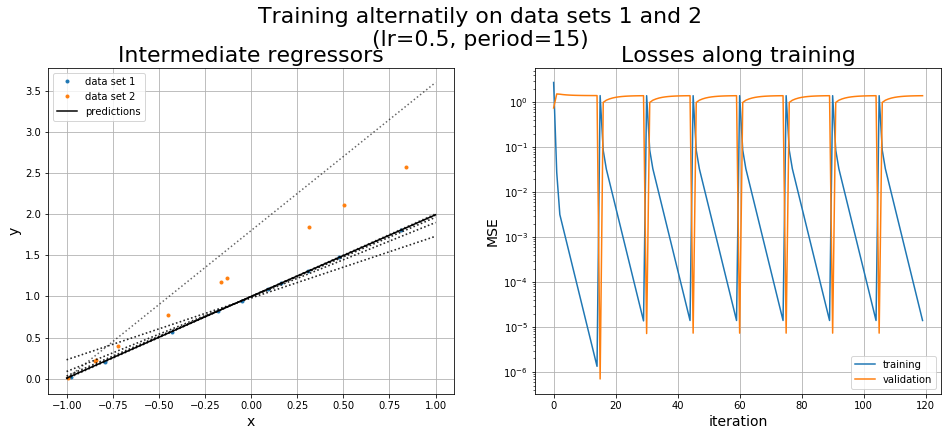

In [5]:
n1, b1, w1 = 10, 1., 1.
c1 = [n1, b1, w1]

n2, b2, w2 = 10, b1 + .4, w1 + .4
c2 = [n2, b2, w2]

b0, w0 = b2 + .4, w2 + .4
c0 = [b0, w0]

lr = .5
period = 15 # period of alternation between data sets 1 and 2 in training
n_epochs = 8*period
n_interm = 10 # approximate number of intermediate regressors to plot

scheme_alternate(c0, c1, c2, n_epochs, lr, n_interm, period)

In [6]:
def scheme_reshuffle(c0, c1, c2, n_epochs, lr, n_interm, period):
    r"""Training alternates data sets 1 and 2 as training and validation sets, with a period `period`.
    """
    b0, w0 = c0
    n1, b1, w1 = c1
    n2, b2, w2 = c2

    h = n_epochs//n_interm # step when slicing to plot intermediate regressors
    
    x1 = -1. + 2.*torch.rand(n1, 1)
    y1 = b1 + w1*x1

    x2 = -1. + 2.*torch.rand(n2, 1)
    y2 = b2 + w2*x2
    
    xx = torch.cat([x1, x2], 0)
    yy = torch.cat([y1, y2],  0) 
    

    # Setup
    model = Linear(1, 1)
    model.weight.data = torch.tensor(w0).view(*model.weight.data.shape)
    model.bias.data = torch.tensor(b0).view(*model.bias.data.shape)


    criterion = MSELoss()
    optimizer = SGD(model.parameters(), lr=lr)

    losses = {}
    losses['training'] = []
    losses['validation'] = []
    weights = []
    biases = []

    # Training
    
    for i in tqdm(range(n_epochs)):
        
        if i % period == 0:
            rows = np.random.permutation(range(n1+n2))
            n_split = len(rows)//2
            rowst, rowsv = rows[:n_split], rows[n_split:]

        xt, xv = xx[rowst,:], xx[rowsv,:]
        yt, yv = yy[rowst,:], yy[rowsv,:]

        weights.append(model.weight.data.item())
        biases.append(model.bias.data.item())
        with torch.no_grad():
            preds_v = model(xt)
            loss_v = criterion(preds_v, yv)
        losses['validation'].append(loss_v.data.item())
        optimizer.zero_grad()
        preds_t = model(xt)
        loss_t = criterion(preds_t, yt)    
        losses['training'].append(loss_t.data.item())
        loss_t.backward()

        optimizer.step()

    weights = torch.tensor(weights).view(1, n_epochs)
    biases = torch.tensor(biases).view(1, n_epochs)

    # Intermediate regressors
    x = torch.linspace(-1., 1., 2).view(-1, 1)
    inputs = torch.ones_like(weights)*x
    outputs = weights*x + biases

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    ax = axs[0]
    ax.plot(x1, y1, '.', label='data set 1')
    ax.plot(x2, y2, '.', label='data set 2');
    ax.plot(inputs[:,::h], outputs[:,::h], ":k", alpha=.6);
    ax.plot(inputs[:,-1], outputs[:,-1], 'k', label='predictions')
    ax.set_xlabel("x", fontsize=14)
    ax.set_ylabel("y", fontsize=14)    
    ax.set_title("Intermediate regressors", fontsize=22)
    ax.legend();
    ax.grid();

    ax = axs[1]
    ax.plot(losses['training'], label='training')
    ax.plot(losses['validation'], label='validation')
    ax.set_xlabel("iteration", fontsize=14)
    ax.set_ylabel("MSE", fontsize=14)
    ax.set_title("Losses along training", fontsize=22)
    ax.legend()
    ax.grid()
    ax.set_yscale('log');

100%|██████████| 300/300 [00:00<00:00, 3258.67it/s]


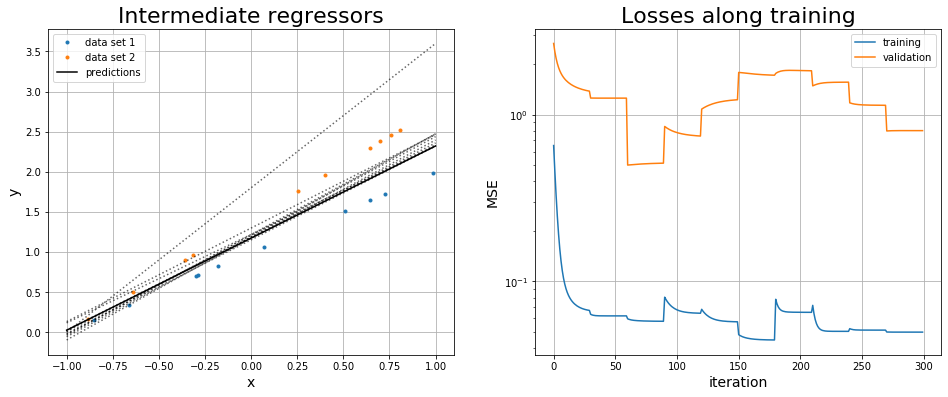

In [7]:
n1, b1, w1 = 10, 1., 1.
c1 = [n1, b1, w1]

n2, b2, w2 = 10, b1 + .4, w1 + .4
c2 = [n2, b2, w2]

b0, w0 = b2 + .4, w2 + .4
c0 = [b0, w0]

lr = .1
period = 30 # period of alternation between data sets 1 and 2 in training
n_periods = 10
n_epochs = n_periods*period
n_interm = 10 # approximate number of intermediate regressors to plot

scheme_reshuffle(c0, c1, c2, n_epochs, lr, n_interm, period)